In [160]:
import torch
import matplotlib.pyplot as plt

print(torch.version.cuda)
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print('Device:', device)

12.4
True
Device: cuda


In [ ]:
from torchvision.transforms import v2
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

transform = v2.Compose([
    v2.RandomCrop(32, padding=4),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = datasets.CIFAR10(root='./data_Cifar10', train=True, download=True,
                                     transform=test_transform,
                                    #  target_transform=v2.Lambda(lambda y: torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).float() * 0.9 + 0.1/10)
                                     )


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


# Load the test dataset
test_dataset = datasets.CIFAR10(root='./data_Cifar10', train=False, download=True,
                                     transform=test_transform,
                                    #  target_transform=v2.Lambda(lambda y: torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).float() * 0.9 + 0.1/10)
                                     )

c:\Users\Dominik\anaconda3\envs\cuda_env\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [162]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.dataset.classes)}")

class_mapping_idx_to_name = dict(enumerate(train_dataset.dataset.classes))
print(f"Class mapping: {class_mapping_idx_to_name}")

class_mapping_name_to_idx = train_dataset.dataset.class_to_idx
print(f"Class mapping: {class_mapping_name_to_idx}")

Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000
Number of classes: 10
Class mapping: {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
Class mapping: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [163]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Cifar10CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128 * 4 * 4, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        logits = self.fc_block(x)
        return logits

In [164]:
num_classes = 10

model = Cifar10CNN(num_classes)

model.to(device)

Cifar10CNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0

In [165]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, scheduler):
    train_losses = []
    val_losses = []
    # device = next(model.parameters()).device  # Get device from model

    print(f"Starting Training")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                # _, true_labels = torch.max(labels, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.2f}%')
        
        scheduler.step()

    return train_losses, val_losses

In [166]:
def test_model(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            # _, true_labels = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    return test_loss, test_accuracy

In [167]:
from torch.optim.lr_scheduler import CosineAnnealingLR
# training and testing configuration
# loss_fn = nn.BCELoss()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
num_epochs = 10

In [168]:
train_losses, val_losses = train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, scheduler)

Starting Training
Epoch [1/10], Train Loss: 1.3966, Validation Loss: 1.0514, Validation Accuracy: 62.34%
Epoch [2/10], Train Loss: 0.9915, Validation Loss: 0.8276, Validation Accuracy: 70.80%
Epoch [3/10], Train Loss: 0.8108, Validation Loss: 0.7242, Validation Accuracy: 73.95%
Epoch [4/10], Train Loss: 0.6961, Validation Loss: 0.6668, Validation Accuracy: 75.98%
Epoch [5/10], Train Loss: 0.5927, Validation Loss: 0.6790, Validation Accuracy: 77.38%
Epoch [6/10], Train Loss: 0.4929, Validation Loss: 0.5530, Validation Accuracy: 80.51%
Epoch [7/10], Train Loss: 0.4001, Validation Loss: 0.5567, Validation Accuracy: 80.86%
Epoch [8/10], Train Loss: 0.3126, Validation Loss: 0.4862, Validation Accuracy: 83.53%
Epoch [9/10], Train Loss: 0.2431, Validation Loss: 0.4719, Validation Accuracy: 84.09%
Epoch [10/10], Train Loss: 0.2028, Validation Loss: 0.4641, Validation Accuracy: 84.61%


In [169]:
test_loss, test_accuracy = test_model(model, test_loader, loss_fn)

Test Loss: 0.4818, Test Accuracy: 84.83%


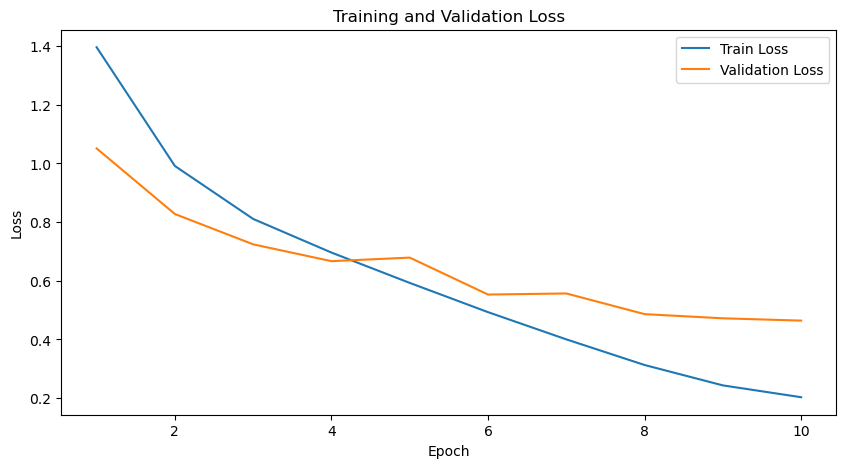

In [170]:
from matplotlib import pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()